In [53]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2

import sys
sys.path.append('../')
from Utils import utils_nn as utlnn

In [54]:
x_test = pd.read_excel("../Train_Test/Dataset_Separado/x_test.xlsx")
x_train = pd.read_excel("../Train_Test/Dataset_Separado/x_train.xlsx")
y_test = pd.read_excel("../Train_Test/Dataset_Separado/y_test.xlsx")
y_train = pd.read_excel("../Train_Test/Dataset_Separado/y_train.xlsx")

In [55]:
## De mi y_train y y_test solo quiero las coordenadas Z
R0 = 6.371E6
out_z_coord = [f'z_{i}' for i in range(1,101)]
y_train_z = y_train[out_z_coord]
y_test_z = y_test[out_z_coord]
# 'y_test_z son las columnas filtradas de las 3 coordenadas'

In [56]:
print("Forma de x_train:", x_train.shape)

for i, col_name in enumerate(x_train.columns):
    col = x_train[col_name]
    print(f"Columna {i} ({col_name}): min={col.min():.4f}, max={col.max():.4f}, mean={col.mean():.4f}, std={col.std():.4f}")


Forma de x_train: (4104, 9)
Columna 0 (latitude_pos_tx): min=-42.2800, max=-42.2800, mean=-42.2800, std=0.0000
Columna 1 (longitude_pos_tx): min=-63.4000, max=-63.4000, mean=-63.4000, std=0.0000
Columna 2 (elevation_pos_tx): min=0.0000, max=0.0000, mean=0.0000, std=0.0000
Columna 3 (fc [Mhz]): min=3.0000, max=30.0000, mean=13.7032, std=6.9191
Columna 4 (elevation): min=0.0000, max=40.0000, mean=13.6659, std=11.8820
Columna 5 (azimuth): min=87.0000, max=98.0000, mean=92.8209, std=4.5824
Columna 6 (year): min=2010.0000, max=2010.0000, mean=2010.0000, std=0.0000
Columna 7 (mmdd): min=101.0000, max=1231.0000, mean=985.1394, std=348.8719
Columna 8 (hour): min=0.0000, max=20.0000, mean=11.1647, std=4.5880


De toda la Información anterior observo que las columnas como.
latitude_pos_tx: -42.28 (valor único y constante)
longitude_pos_tx: -63.40 (valor único y constante)
elevation_pos_tx: 0.0 (valor único y constante)
year: 2010 (valor único y constante)

Estas 4 columnas tienen desviacion estándar 0, es decir, no aportan nada al aprendizaje del modelo.\
**Nota**: Los modelos de ML aprenden de las variaciones, y esas columnas no tienen ninguna.\
Procedemos a quitarlos del x_train/test

In [57]:
x_train = x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test = x_test.drop(columns =['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [58]:
#Normalizamos la salida
from sklearn.preprocessing import MinMaxScaler

scaler_z = MinMaxScaler()
y_train_z_scaled = scaler_z.fit_transform(y_train_z)
y_test_z_scaled = scaler_z.transform(y_test_z)

In [59]:
# epoch = 1160 #1160
# b_s = 70
# act_name = 'relu'
# l2_reg = 0.003
# optimizer_name= 'adamW'
# while epoch <= 1500:
#   while b_s <= 130:
    
#     inputs = Input(shape=(9,))
#     encoded = Dense(9, activation= act_name, kernel_regularizer= l2(l2_reg))(inputs)
#     encoded = Dense(16, activation= act_name)(encoded) #, kernel_regularizer= l2(l2_reg)
#     encoded = Dense(32, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded)
#     encoded = Dense(64, activation= act_name)(encoded) # , kernel_regularizer= l2(l2_reg)
#     encoded = Dense(80, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded)
#     encoded = Dense(90, activation= act_name)(encoded) #, kernel_regularizer= l2(l2_reg)
#     decoded = Dense(100, activation= 'linear', kernel_regularizer= l2(l2_reg), name ='z_output')(encoded)

#     autoencoder_y = Model(inputs, decoded)
#     autoencoder_y.compile(optimizer = optimizer_name, loss= 'mse')
#     autoencoder_y.summary()

#     history = autoencoder_y.fit(x_train,y_train_z,
#                                 epochs = epoch,
#                                 batch_size = b_s,
#                                 validation_split = 0.1)
    
#     loss = autoencoder_y.evaluate(x_test,y_test_z)

#     if loss <= 60: # 35
#       autoencoder_y.save(f'../modelos_entrenamiento/modelos_z/mod_z_{epoch}_{b_s}_vs10_{optimizer_name}_loss_{round(loss)}.keras')
#     print(f'Pérdida en datos de Test: {loss} epoch: {epoch}, batch_size: {b_s}')
#     b_s +=20
#   b_s = 80
#   epoch +=40

In [60]:
early_stopping = EarlyStopping(
  monitor = 'val_loss',	#monitoriamos la pérdida en validación
  patience = 20, # Si no mejora en 10->20 epochs, detenemos el entrenamiento.
  restore_best_weights = True # Restaura los mejores pesos encontrados.
)
reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss',
  patience = 10,
  factor = 0.5
)

In [66]:
act_name = "relu"
l2_reg = 0.0
epoch = 1000
b_s= 48
optimizer_name = "adam"

inputs = Input(shape=(5,))
encoded = Dense(5, activation= act_name, kernel_regularizer= l2(l2_reg))(inputs)
# encoded = Dense(16, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded) #, 
encoded = Dense(32, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded)
encoded = Dense(64, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded) # , kernel_regularizer= l2(l2_reg)
# encoded = Dense(80, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded)
# encoded = Dense(90, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded) #, kernel_regularizer= l2(l2_reg)
decoded = Dense(100, activation= 'linear', kernel_regularizer= l2(l2_reg), name ='z_output')(encoded)

autoencoder_z = Model(inputs, decoded)
autoencoder_z.compile(optimizer = optimizer_name, loss= 'mse',metrics = ['mae'])
autoencoder_z.summary()

history = autoencoder_z.fit(x_train,y_train_z,
														epochs = epoch,
														batch_size = b_s,
														validation_split = 0.1,
                            callbacks = [early_stopping, reduce_lr]
                            )

loss = autoencoder_z.evaluate(x_test,y_test_z)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_output (Dense)                │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,834 (34.51 KB)

 Trainable params: 8,834 (34.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3815.8892 - mae: 43.0406 - val_loss: 1953.2415 - val_mae: 31.7968 - learning_rate: 0.0010
Epoch 2/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1973.1624 - mae: 31.2205 - val_loss: 1784.0580 - val_mae: 29.7742 - learning_rate: 0.0010
Epoch 3/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1807.8328 - mae: 30.2525 - val_loss: 1720.2910 - val_mae: 28.9412 - learning_rate: 0.0010
Epoch 4/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1679.0437 - mae: 29.1992 - val_loss: 1697.6031 - val_mae: 29.0831 - learning_rate: 0.0010
Epoch 5/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1637.6532 - mae: 29.1981 - val_loss: 1675.2380 - val_mae: 28.6901 - learning_rate: 0.0010
Epoch 6/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1642.3141 - mae: 29.0352 - val_loss: 1653.2371 - val_mae: 28.5876 - learning_rate: 0.0010
Epoch 7/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1598.5482 - mae: 28.5965 - val_loss: 162

In [67]:
loss = autoencoder_z.evaluate(x_test,y_test_z)
print(f'Pérdida en datos de Test: {loss}')

mae_in_m = loss[1]*R0
print(f'mae:{mae_in_m}[m]')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 485.7858 - mae: 11.5831
Pérdida en datos de Test: [437.19464111328125, 11.170164108276367]
mae:71165115.53382874[m]


In [68]:
idx = 2

 # Elegir una muestra para comparar (observar luego la muestra 30)

# Predicción de una muestra 
y_pred_scaled = autoencoder_z.predict(np.expand_dims(x_test.iloc[idx], axis=0))
###############################################
y_true = y_test_z.iloc[idx] # Se obtine Algo de tipo Serie
y_true=y_true.to_numpy() # Transform a Numpy array

#Desnormalizamos
y_pred = scaler_z.inverse_transform(y_pred_scaled)

y_pred = y_pred.flatten() # [[...,...,...,....,]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


In [69]:
y_pred

array([4.48077768e-01, 1.01075354e+01, 3.55674591e+01, 7.57110672e+01,
       1.30902237e+02, 2.06429703e+02, 2.89408875e+02, 3.93725403e+02,
       5.29241760e+02, 6.68669312e+02, 8.33652344e+02, 1.01122522e+03,
       1.22392493e+03, 1.48270752e+03, 1.75594983e+03, 2.06547729e+03,
       2.39354370e+03, 2.76061646e+03, 3.10572974e+03, 3.50561963e+03,
       3.87141528e+03, 4.27199561e+03, 4.82306396e+03, 5.45916406e+03,
       6.08846191e+03, 6.66957617e+03, 7.30144287e+03, 7.82518799e+03,
       8.44919629e+03, 8.99634082e+03, 9.48702246e+03, 9.97394824e+03,
       1.05443037e+04, 1.10592080e+04, 1.16060684e+04, 1.21077207e+04,
       1.26654639e+04, 1.30886045e+04, 1.36613623e+04, 1.41818818e+04,
       1.46952959e+04, 1.51265703e+04, 1.56665488e+04, 1.61767539e+04,
       1.67691641e+04, 1.72946934e+04, 1.77289062e+04, 1.81423535e+04,
       1.86234863e+04, 1.90725000e+04, 1.94456250e+04, 1.98205566e+04,
       2.01353555e+04, 2.08274160e+04, 2.14248262e+04, 2.20552988e+04,
      

In [72]:
y_true

array([  0.44775896,   1.99148385,   3.54232707,   5.10028238,
         6.66534353,   8.23802392,   9.82767563,  11.42442209,
        13.028257  ,  14.63917406,  16.25819912,  17.89358734,
        19.53604558,  21.18556747,  22.84214665,  24.5073068 ,
        26.18818526,  27.87610752,  29.57106716,  31.27305774,
        32.98404148,  34.70992017,  36.442814  ,  38.1827165 ,
        39.92962116,  41.67925046,  43.42298711,  45.17359645,
        46.93107205,  48.69540745,  50.45937633,  52.21325849,
        53.97384698,  55.74113545,  57.51511753,  59.28931984,
        61.05811835,  62.83348104,  64.6154016 ,  66.40387373,
        68.18757523,  69.96073882,  71.74028792,  73.52621632,
        75.31851781,  77.09795907,  78.86011811,  80.62843438,
        82.4029018 ,  84.18351431,  85.94450405,  87.6856959 ,
        89.4327894 ,  91.18577866,  92.94465781,  94.68031203,
        96.39785308,  98.12104081,  99.84986954, 101.58433354,
       103.29510182, 104.99178028, 106.69387268, 108.40

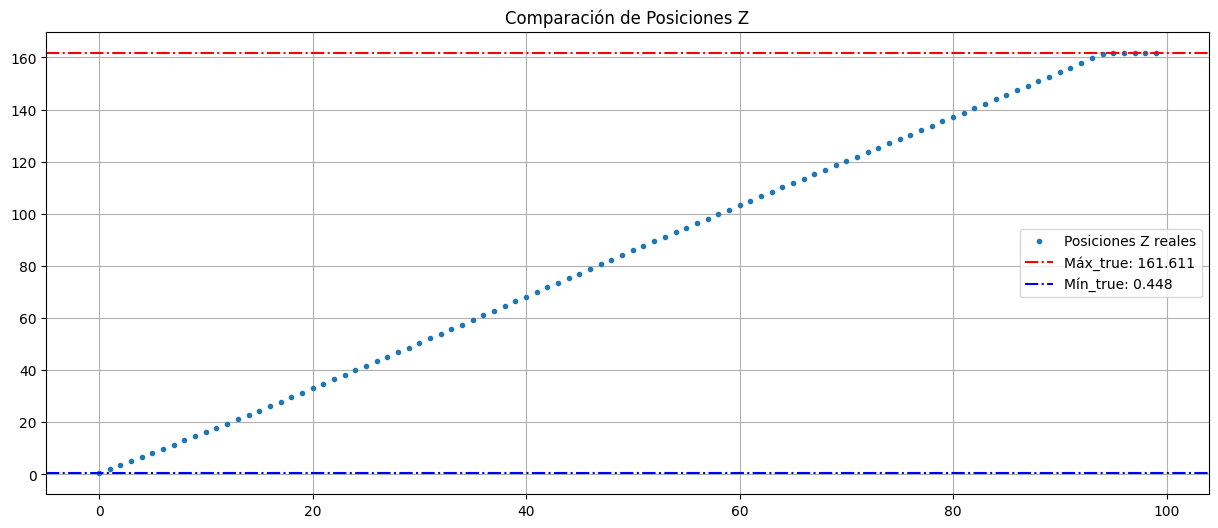

In [71]:
##Graficamos 
# Buscamos los máximos y mínimos 
y_true_max = np.max(y_true)
y_true_min = np.min(y_true)

y_pred_max = np.max(y_pred)
y_pred_min = np.min(y_pred)

# Pos y
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Posiciones Z reales', linestyle='None', marker='.')
# plt.plot(y_pred, label='Posiciones Z predichas', linestyle = 'None',marker='o')
# Dibujamos los max y min
plt.axhline(y = y_true_max, color = 'red', linestyle = '-.', label=f'Máx_true: {y_true_max:.3f}')
# plt.axhline(y = y_pred_max, color = 'red', linestyle = ':', label= f'Máx_pred: {y_pred_max:.3f}')
plt.axhline(y = y_true_min, color = 'blue', linestyle ='-.', label=f'Mín_true: {y_true_min:.3f}')
# plt.axhline(y = y_pred_min, color = 'blue', linestyle = ':',label= f'Mín_pred:{y_pred_min: .3f}')

# plt.ylim(-35,-50) ##(-60,-30)
plt.title('Comparación de Posiciones Z')
plt.legend()
plt.grid(True)
plt.show()